In [45]:
%load_ext autoreload
%autoreload 2
import os
from copy import deepcopy
import sys
from os.path import join as oj
sys.path.append('..')

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
import matching
from tqdm import tqdm
from collections import OrderedDict
from config import *
from style import cb, cr, cg, cp
import data
import util
import viz

# df contains filenames, ids, and attributes
df = data.load_all_labs()
df = df.set_index('fname_id')
k_group = 'gender'

# print([k for k in os.listdir(DIR_PROCESSED_MISC) if '14_' in k])
matches = pd.read_pickle(oj(DIR_PROCESSED_MISC, '14_matches_gender_200.pkl'))

# match indexes are in original space [0, 30000)
# this is the same as the df.index [0, 30000)
match_keys = OrderedDict({
    f'{k_group}_0_ref': 'dist_ref0',
    f'{k_group}_0': 'dist',
    f'{k_group}_1': 'dist',
    f'{k_group}_1_ref': 'dist_ref1'
})
ks_matched = [k for k in match_keys if not 'ref' in k]
idxs_matched = matches[ks_matched].values
d_matched = df.iloc[idxs_matched.flatten()]

# add Race = Black
df['black'] = 0
df.loc[df['race4_pred'] == 'Black', 'black'] = 1
d_matched['black'] = 0
d_matched.loc[d_matched['race4_pred'] == 'Black', 'black'] = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [2]:
dists_vgg = data.get_dists('vgg')

# look at some matches

In [3]:
ks = match_keys.keys()
r = {k: [] for k in match_keys.keys()}
# load the images
for i, match in tqdm(matches.iterrows()):
    for k in r.keys():
        d = df.iloc[int(match[k])]
        r[k].append(mpimg.imread(oj(DIR_IMS, d.fname_final)))

200it [00:13, 14.36it/s]


In [ ]:
for row_num in range(8):
    N_PER_ROW = 6
    N_SKIP = 1

    ks_plot = list(ks)[1: 3]
    ylabs = [k.replace('gender_0', 'Female').replace('gender_1', 'Male') for k in ks_plot]

    # plot the images
    for i, k in enumerate(ks_plot):
        if not 'ref' in k:
            annot_list = None
        else:
            annot_list = matches[match_keys[k]][row_num * N_PLOT: (row_num + 1) * N_PLOT].round(1)
        util.plot_row(r[k][::N_SKIP][row_num * N_PLOT: (row_num + 1) * N_PLOT],
                      annot_list=annot_list,
                      ylab=ylabs[i],
                      fontsize_ylab=42)
        util.savefig(f'matches_{k}_{row_num}')
        plt.show()

In [ ]:
N_PLOT = 10
N_SKIP = 10

ks_plot = list(ks)[1: 3]
ylabs = [k.replace('gender_0', 'Female').replace('gender_1', 'Male') for k in ks_plot]

# plot the images
for i, k in enumerate(ks_plot):
    if not 'ref' in k:
        annot_list = None
    else:
        annot_list = matches[match_keys[k]][:N_PLOT].round(1)
    util.plot_row(r[k][::N_SKIP][:N_PLOT],
                  annot_list=annot_list,
                  ylab=ylabs[i],
                  fontsize_ylab=42)
    util.savefig(f'matches_big_{k}')
    plt.show()

# mean diff checking

In [ ]:
d_matched['black']

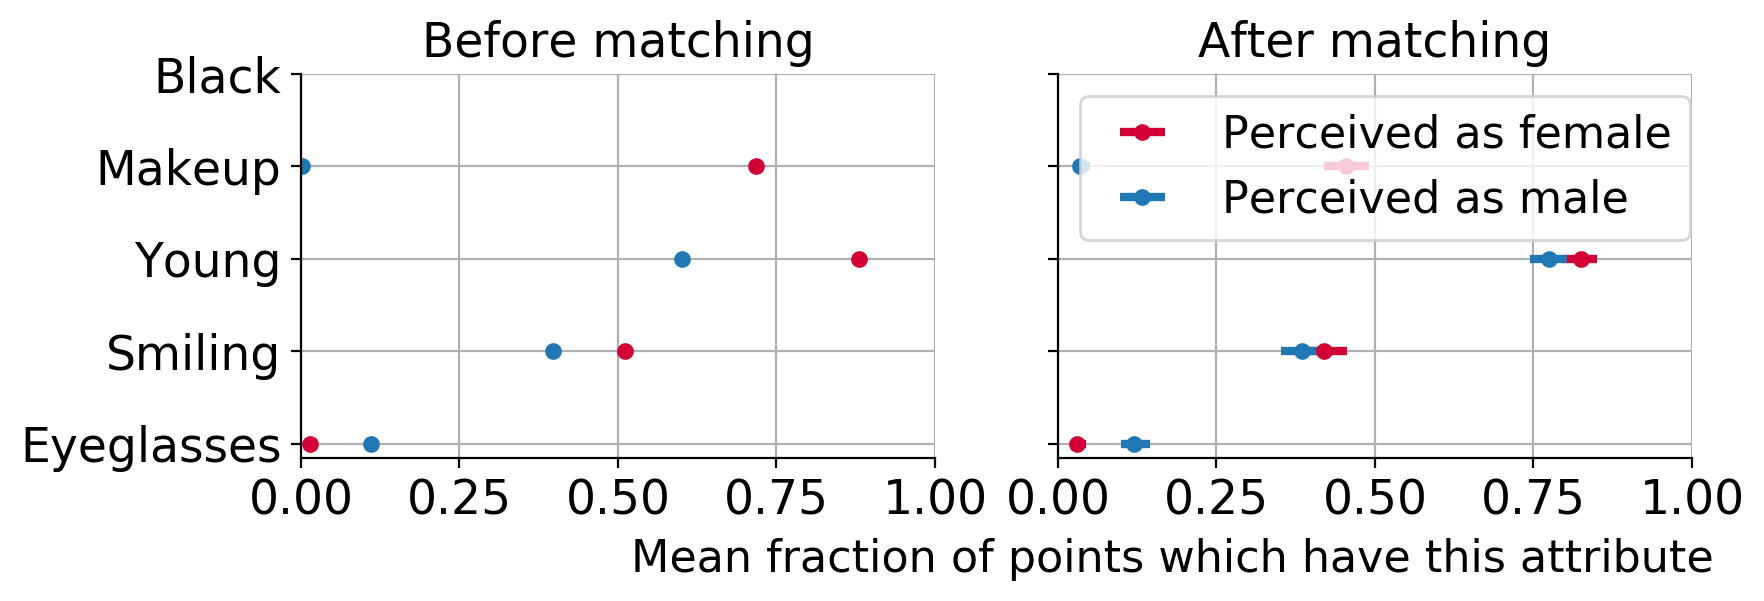

In [24]:
R, C = 1, 2
fig = plt.figure(dpi=200, figsize=(12, 3))
ks = [ #'yaw', 'pitch', 'roll',
      'eyeglasses', 'makeup', 'gender',
      'black', 'young', 'smiling'] #, 'background_mean']
args = None
colors = [cr, cb]
titles = ['Before matching', 'After matching']
for i, d in enumerate([df, d_matched]):
    
    d = d[ks]

    # normalize to [0, 1]
    d = (d - d.min()) / (d.max() - d.min())
    
    g0 = d[d[k_group] == 0]
    g1 = d[d[k_group] == 1]
    
    ax = plt.subplot(R, C, i + 1)
    args = viz.plot_subgroup_means(g0, g1,
                                        ks=np.array([k for k in ks if not k == k_group]),
                                        CI='wilson',
                                        ticklabels=i == 0, args=args, colors=colors)
    plt.title(titles[i])
    plt.xlim((0, 1))
fig.text(0.5, 0, 'Mean fraction of points which have this attribute', ha='center')
    
plt.legend(bbox_to_anchor=(1, 0.5))
util.savefig('means_matching')
plt.legend()    
plt.show()

# secondary match dist checking

**dists between ref and matched photos**

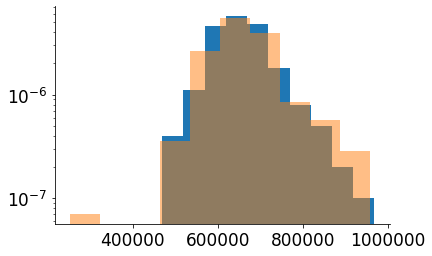

In [121]:
density = True
ks0 = [k for k in match_keys if '_0' in k]
ds_vgg0 = [dists_vgg[x[0], x[1]] for x in matches[ks0].values]
ks1 = [k for k in match_keys if '1' in k]
ds_vgg1 = [dists_vgg[x[0], x[1]] for x in matches[ks1].values]
plt.hist(ds_vgg0, density=density, bins=10)
plt.hist(ds_vgg1, density=density, alpha=0.5, bins=10)
plt.yscale('log')
plt.show()

**dists for random pairs in original data**

In [ ]:
ds_orig = {
    0: [],
    1: [],
}
for val in ds_orig.keys():
    d = df[df['count_with_this_id'] > 1]
    d = d[d[k_group] == val]
    ids = sorted(d.id.unique())
    for i in tqdm(ids):
        r2 = d[d.id == i][:2].index.values.astype(int) - 1 # first 2 ims
        ds_orig[val].append(dists_vgg[r2[0], r2[1]])
plt.hist(ds_orig[0], density=density)
plt.hist(ds_orig[1], density=density, alpha=0.5)
plt.yscale('log')

# facial-rec dist benchmarking

In [11]:
dists_facial = data.get_dists('facial')
dists_facial2 = data.get_dists('facenet_vgg2')
dists_facial3 = data.get_dists('facenet_casia')

**calculate original dists**

In [12]:
THRESH = 0.6
def hist_dists(r, density=True):
    plt.hist(1 - np.array(r[0]), density=density, cumulative=True)
    plt.hist(1 - np.array(r[1]), density=density, alpha=0.5, cumulative=True)
    plt.yscale('log')
    plt.xlabel('Facial similarity (dllib) for image\npairs with the same identity')
    plt.ylabel('Density')
    plt.axvline(1 - THRESH, linestyle='--', color='gray', alpha=1)
#     plt.legend(title=attr.capitalize(), loc='lower right', framealpha=1)
    plt.show()
    
def calc_dists_orig(df, dists):
    '''Calculate distances for pairs in original data
    '''
    ds_orig = { 0: [], 1: [] }
    for val in ds_orig.keys():
        d = df[df['count_with_this_id'] > 1]
        d = d[d[k_group] == val]
        ids = sorted(d.id.unique())
        for i in tqdm(ids):
            r2 = d[d.id == i][:2].index.values.astype(int) - 1 # first 2 ims
            dist = dists[r2[0], r2[1]]
            if not dist == 1e3:
                ds_orig[val].append(dist)
    ds_orig = {k: np.array(ds_orig[k]) for k in ds_orig.keys()}
    return ds_orig


def calc_dists_matches(df, dists): 
    '''Calculate distances for pairs after matching
    '''
    r = {}
    accs = {}
    for i in [0, 1]:
        idxs_match = matches[k_group + '_' + str(i)].values
        idxs_ref = matches[k_group + '_' + str(i) + '_ref'].values
        r[i] = np.array([dists[r, c]
                for (r, c) in zip(idxs_match, idxs_ref)
                if not dists[r, c] == 1e3])
        accs[i] = np.array(r[i]) < THRESH
    return r

In [15]:
dist_names = ['dlib', 'facenet-vggface2', 'facenet-casia']
ds_orig_list = {}
accs_orig_list = {}
ds_matches_list = {}
accs_matches_list = {}
for k, dists in zip(dist_names, [dists_facial, dists_facial2, dists_facial3]):
    # original dists
    ds_orig_list[k] = calc_dists_orig(df, dists)
    accs_orig_list[k] = {kk: ds_orig_list[k][kk] < THRESH for kk in ds_orig_list[k].keys()}
    # hist_dists(ds_orig)

    # new dists
    ds_matches_list[k] = calc_dists_matches(df, dists)
    accs_matches_list[k] = {kk: ds_matches_list[k][kk] < THRESH for kk in ds_matches_list[k].keys()}
    # hist_dists(r)

100%|██████████| 1880/1880 [00:01<00:00, 1058.69it/s]


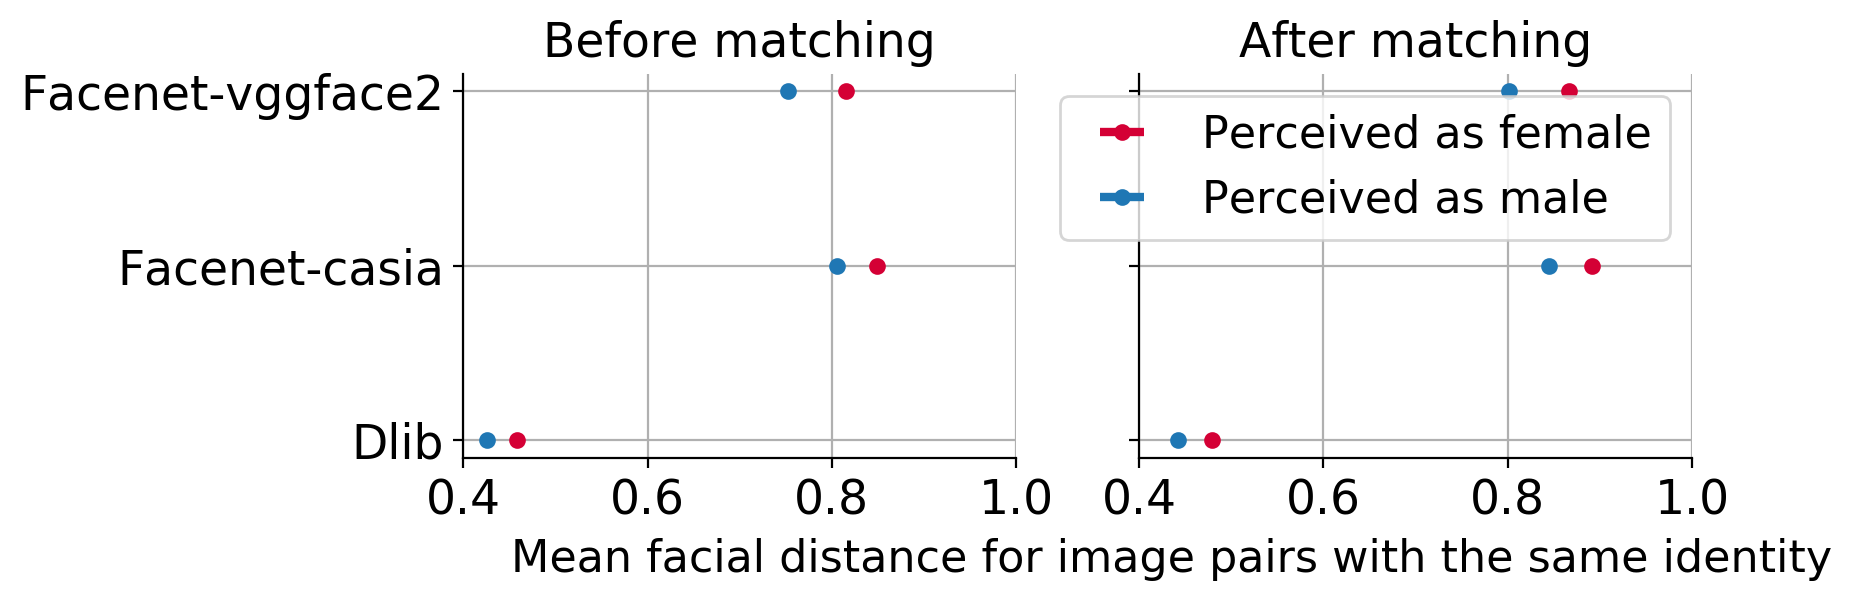

In [25]:
R, C = 1, 2
fig = plt.figure(dpi=200, figsize=(12, 3))

colors = [cr, cb]
titles = ['Before matching', 'After matching']
for i, d in enumerate([ds_orig_list, ds_matches_list]):
# for i, d in enumerate([accs_orig_list, accs_matches_list]):    
    g0 = {k: d[k][0] for k in d.keys()}
    g1 = {k: d[k][1] for k in d}
    
    ax = plt.subplot(R, C, i + 1)
    args = viz.plot_subgroup_means(g0, g1, ks=np.array(dist_names),
                                        CI='wilson',
                                        ticklabels=i == 0, colors=colors)
    plt.xlim((0.4, 1))
    plt.title(titles[i])
fig.text(0.5, 0, 'Mean facial distance for image pairs with the same identity', ha='center')
        
plt.legend(bbox_to_anchor=(1, 0.5))
util.savefig('dists_matching')
plt.legend()    
plt.show()

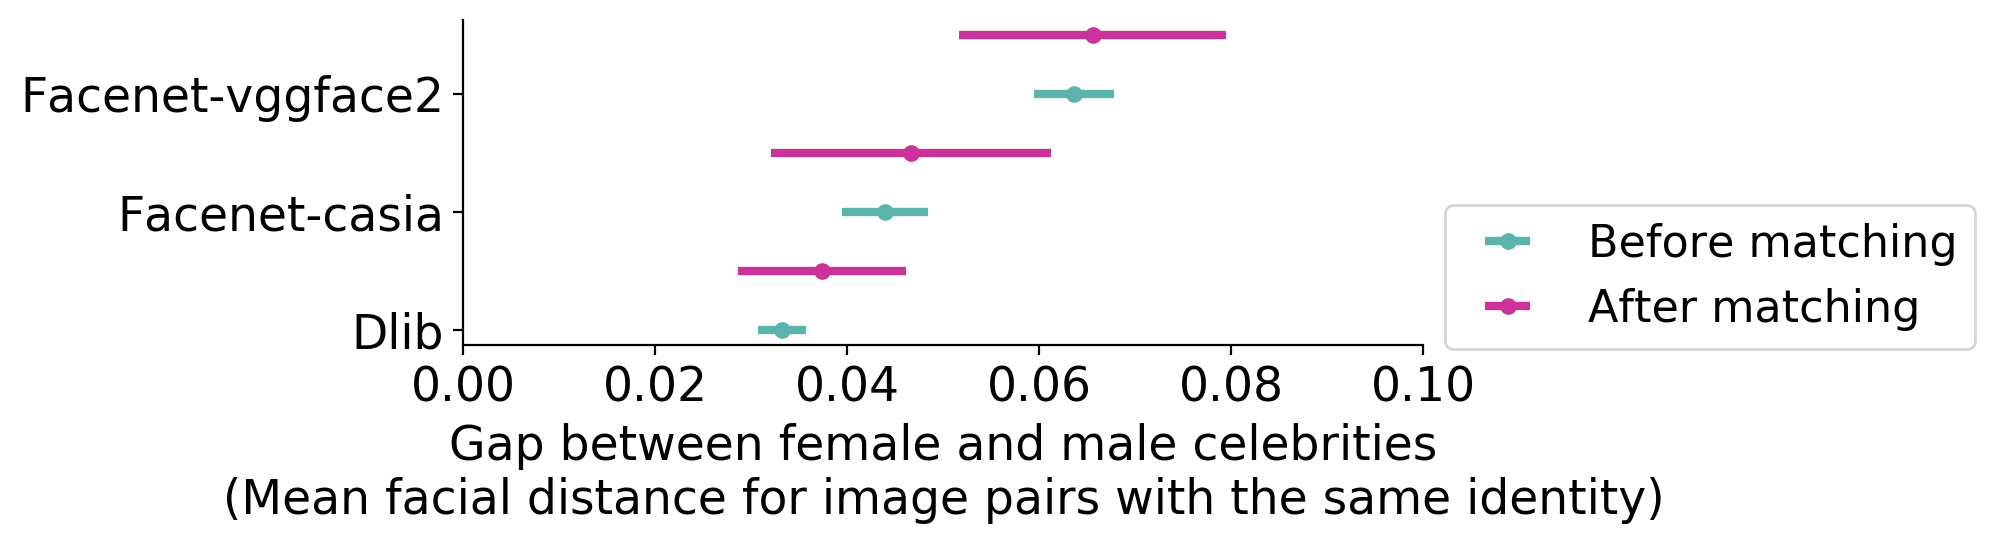

In [60]:
# R, C = 1, 2
fig = plt.figure(dpi=200, figsize=(8, 3))

colors = [cg, cp]
labs = ['Before matching', 'After matching']
for i, d in enumerate([ds_orig_list, ds_matches_list]):
# for i, d in enumerate([accs_orig_list, accs_matches_list]):    
    g0 = {k: d[k][0] for k in d.keys()}
    g1 = {k: d[k][1] for k in d}
    
    ks = np.array(dist_names)
    
    means0 = np.array([np.mean(g0[k]) for k in ks])
    means1 = np.array([np.mean(g1[k]) for k in ks])
    args = np.argsort(np.abs(means0 - means1))
     
    lists = [g0[k] for k in ks]
    means0 = np.array([np.mean(l) for l in lists])
    sems0 = np.array([np.std(l) / np.sqrt(l.size) for l in lists])
    lists = [g1[k] for k in ks]
    means1 = np.array([np.mean(l) for l in lists])
    sems1 = np.array([np.std(l) / np.sqrt(l.size) for l in lists])
    ys = np.arange(len(ks))
    plt.errorbar(means0[args] - means1[args], ys + i * 0.5, xerr=sems0, label=labs[i],
                 linestyle='', marker='.', markersize=10, color=colors[i])
    plt.grid()
    
    plt.xlim((0, 0.1))
    plt.yticks(np.arange(len(ks)), [k.capitalize().replace('_', ' ') for k in ks[args]])
plt.xlabel('Gap between female and male celebrities\n(Mean facial distance for image pairs with the same identity)')
        
plt.legend(bbox_to_anchor=(1, 0.5))
util.savefig('dists_matching')
# plt.legend()    
plt.show()